# 01 Starter: Loading and Viewing the NWB Data

This notebook walks through the NWB data loading and conversion tools, as well as providing some simple visualizations for LINK dataset.

### 1. Download LINK Dataset

We need to first install DANDI-cli tool for downloading the dataset. By default (of the series of tutorial notebooks) it downloads data to the root directory.

In [1]:
# Install dandi
%pip install dandi
# Download LINK dataset using dandi

!dandi download DANDI:001201 -o ../data

Note: you may need to restart the kernel to use updated packages.
PATH                 SIZE DONE    DONE% CHECKSUM STATUS MESSAGE   
001201/dandiset.yaml                                    updating  
Summary:                  0 Bytes                       1 updating
                          <0.00%                                  
PATH                 SIZE DONE    DONE% CHECKSUM STATUS    MESSAGE    
001201/dandiset.yaml                             skipped   no change  
Summary:                  0 Bytes                1 skipped 1 no change
                          <0.00%                                      PATH                         SIZE     DONE    DONE% CHECKSUM STATUS    MESSAGE  
001201/dandiset.yaml                                         skipped   no change
..._ses-20200127_ecephys.nwb                                                    
Summary:                     0 Bytes  0 Bytes                1 skipped 1 no c...
                             >+4.2 GB <0.00%               

Double check that data is downloaded to the root directory by examine that if a folder called 001201 exists with various nwb files in its sub-Monkey-N subfolder. Run the following cell, there should be 312 NWB files found.

In [2]:
import os
dataset_dir = os.path.join('..', 'data', '001201')
subfolder = os.path.join(dataset_dir, 'sub-Monkey-N')

if os.path.isdir(dataset_dir) and os.path.isdir(subfolder):
    nwb_files = [f for f in os.listdir(subfolder) if f.endswith('.nwb')]
    if nwb_files:
        print(f"Data is downloaded. Found {len(nwb_files)} NWB files in {subfolder}:")
    else:
        print(f"No NWB files found in {subfolder}.")
else:
    print(f"Dataset folder or subfolder not found at {subfolder}.")

Data is downloaded. Found 312 NWB files in ../data/001201/sub-Monkey-N:


### 2. Accessing NWB Files Directly Using PyNWB


We will need to install pynwb library for accessing NWB files in python.

In [3]:
# Install pynwb
%pip install -U pynwb

Note: you may need to restart the kernel to use updated packages.


We import pynwb here and look at the overall structure for the first nwb file. [TODO: some help here describing what NWB file contains]

In [4]:
from pynwb import NWBHDF5IO

dataset_dir = os.path.join('..', 'data', '001201')
subfolder = os.path.join(dataset_dir, 'sub-Monkey-N')

nwb_path = os.path.join(subfolder, nwb_files[0])
with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    print(nwbfile)

root pynwb.file.NWBFile at 0x136076814782864
Fields:
  analysis: {
    SpikingBandPower <class 'pynwb.ecephys.ElectricalSeries'>,
    ThresholdCrossings <class 'pynwb.ecephys.ElectricalSeries'>,
    index_position <class 'pynwb.base.TimeSeries'>,
    index_velocity <class 'pynwb.base.TimeSeries'>,
    mrs_position <class 'pynwb.base.TimeSeries'>,
    mrs_velocity <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Lateral <class 'pynwb.device.Device'>,
    Medial <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Lateral <class 'pynwb.ecephys.ElectrodeGroup'>,
    Medial <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Behavioral and neural data from Utah Array recordings from a macaque doing finger movements
  experimenter: ['Chestek Lab']
  file_create_date: [datetime.datetime(2025, 5, 16, 1, 35, 30, 902291, tzinfo=tzutc())]
  identifier: 2023-04-04_0      RD
1      RD
2      RD
3      RD


Here we examine a simple case of neural and behavioural data.

To look at the neural data, analysis section needs to be accessed. For neural data, it contains spiking band power and threshold crossing. For behavioural data, it contains index position, MRS position, index velocity, and MRS velocity. 

In this NWB file, each type of neural data contains a matrix of (27649, 96), corresponding to (n_TimeBins, n_Channels) in general. For each type of behavioural data, it contains a matrix of (27649, 1).

[TODO: talk about what unit is in SBP and why /0.25]

The following cell access the analysis section of the NWB file and organises neural data into a ndarray called sbp and behavioural data into a ndarray called kinematic_names.

In [5]:
import numpy as np
kinematic_names =   (
                    "index_position",
                    "mrs_position",
                    "index_velocity",
                    "mrs_velocity",
                    )

with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    sbp = (nwbfile.analysis["SpikingBandPower"].data[:] / 0.25).astype(np.float64)
    
    finger_kinematics = np.column_stack(
                                        [nwbfile.analysis[f"{n}"].data[:].ravel() 
                                        for n in kinematic_names]
                                        ).astype(np.float64)


Here is a simple plot to demonstrate what these data look like. Channel 30 is selected from the SBP data arbitrarily.

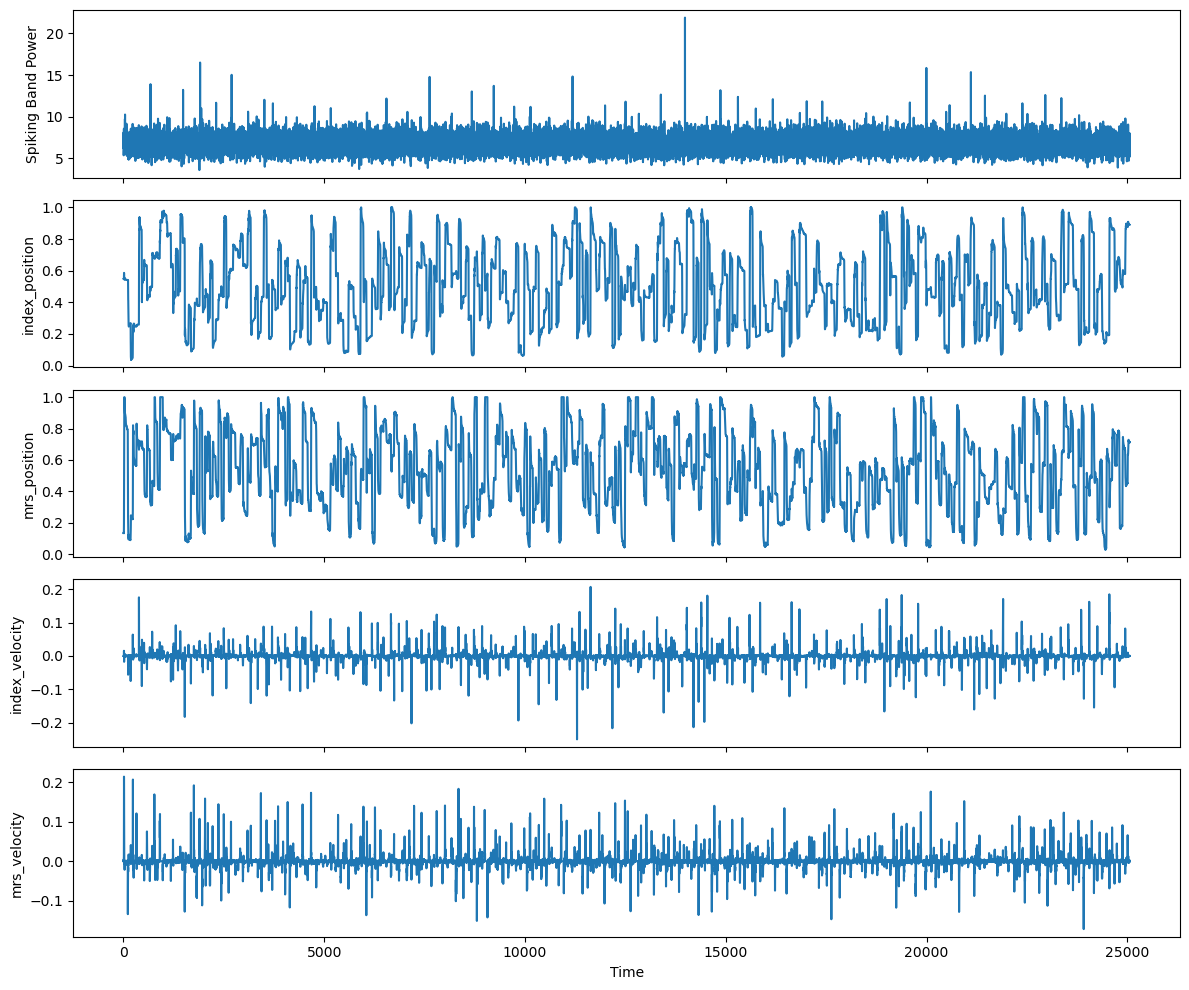

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
axs[0].plot(sbp[:,30])
axs[0].set_ylabel('Spiking Band Power')

for i in range(4):
    axs[i+1].plot(finger_kinematics[:,i])
    axs[i+1].set_ylabel(f'{kinematic_names[i]}')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

### 2. Converting NWB Files Using nwb_tools

nwb_tools.py is provided for easier access and conversion of NWB files to downstream tasks. We start by importing nwb_tools.

In [7]:
# Setting working directory to root to mimic usual usecase
###############################################################
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, root_path)
###############################################################

from utils import nwb_tools

load_one_nwb tool converts one nwb file into dictionary, as shown below,

In [8]:
dict_from_nwb = nwb_tools.load_one_nwb(os.path.join(subfolder, nwb_files[0]))
print(dict_from_nwb)

{'trial_number': array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 

Here is another tool to convert all NWB data into pkl files for downstream applications.

[TODO: talk about what pickle files contain]

In [9]:
data_path = dataset_dir
output_path = os.path.join(dataset_dir, '../pickles')
if not os.path.exists(output_path):
    os.makedirs(output_path)

nwb_tools.convert_dandi_nwb_to_pkl(data_path, output_path)

100%|██████████| 303/303 [00:02<00:00, 114.15it/s]
